In [38]:
from trajectories import *
from simplicial_paths import *

# Toy Example

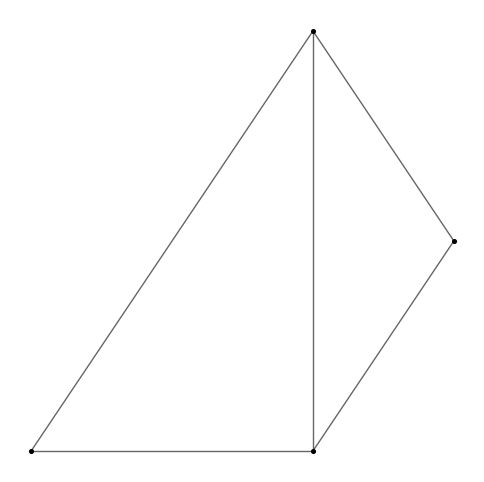

Harmonic Projection Matrix:
[[ 0.61075746 -0.04444466]
 [-0.61075746  0.04444466]
 [ 0.44907446  0.54619788]
 [ 0.161683   -0.59064254]
 [-0.161683    0.59064254]]


In [39]:
pts = np.array([(1,0), (0,1),  (0,-1), (-2, -1)])
SC = SimplicialComplex(pts, True)
all_edges = np.array([0,1,2,3,4])
edges_to_add = {1:set(all_edges)}
coord_pairs = [[tuple(SC.nodes[i]), tuple(SC.nodes[j]), (i,j)] for (i,j) in SC.edges]
SC.add_simplices(edges_to_add)
plt.figure(figsize=(6,6))
SC.plot()
plt.show()

print("Harmonic Projection Matrix:")
print(SC.H)


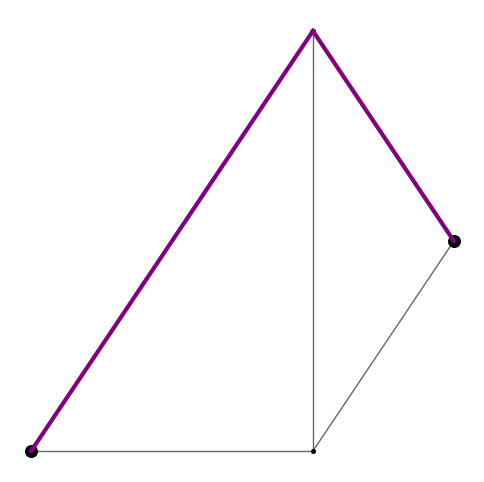

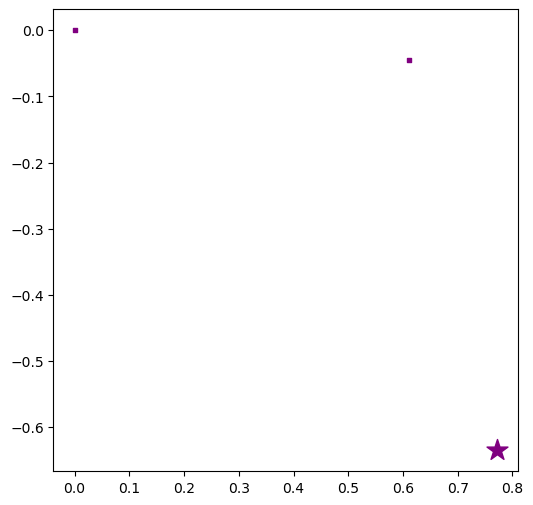

[[ 0.77244045 -0.6350872 ]]


In [40]:
ref_path = Trajectory(SC, None, None, None)
ref_path.set([(0,1), (1,3)])

color = 'purple'

plt.figure(figsize=(6,6))
SC.plot_trajectories(ref_path.all_trajectories, color)
plt.show()

plt.figure(figsize=(6,6))
x_ref, ref_edge_seq = ref_path.trajectory_to_edgevec(ref_path.all_trajectories[0])
ref_proj_seq, ref_proj_fin = ref_path.project_trajectories()
ref_path.plot_trajectory_proj('reference', color)
plt.show()
print(ref_path.project_trajectories()[1])

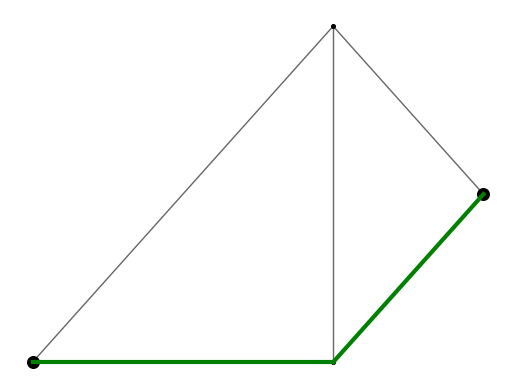

<Figure size 600x600 with 0 Axes>

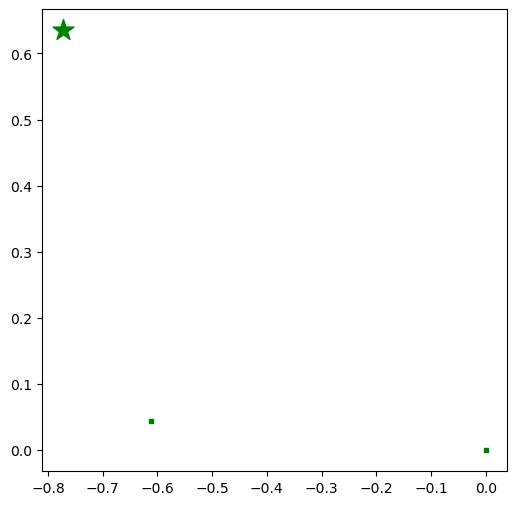

In [41]:
color = 'green'
shortest_path = Trajectory(SC, [(1,0), (-2,-1)], 1, 1)

SC.plot_trajectories(shortest_path.all_trajectories, color)

plt.figure(figsize=(6,6))
x_shortest, shortest_edge_seq = shortest_path.trajectory_to_edgevec(shortest_path.all_trajectories[0])
plt.show()

plt.figure(figsize=(6,6))
shortest_path.plot_trajectory_proj('reference', color)
plt.show()

In [42]:
print("Difference in projection")
proj_diff = shortest_path.project_trajectories()[1] - ref_path.project_trajectories()[1]
print(np.linalg.norm(proj_diff)**2)

Difference in projection
3.999999999999999


# Augmented Dijkstra Implementation

In [43]:
def compute_edge_proj(SC, edge):
    e1, e2 = edge
    parity = -2 * int(e1 > e2) + 1
    actual_edge = ( min([e1, e2]), max([e1, e2]) )
    x_vec = np.zeros_like(SC.edge_vec)
    edge_idx = SC.edges.index(actual_edge)
    x_vec[edge_idx] += parity
    proj = SC.harm_proj(x_vec)
    return proj

def augmented_dijkstra(SC, init_node, goal_node, ref_proj, alpha):
    """
    G: Graph from simplicial complex
    v_init: starting node
    ref_proj: projection of reference path
    alpha: regularization parameter
    """
    num_holes = SC.num_holes
    G = SC.graph
    num_nodes = SC.node_vec.shape[0]
    prev = np.ones(num_nodes, dtype=int) * -1
    dist = np.ones((num_nodes, 2)) * np.inf
    dist[:,1] = np.arange(num_nodes)
    proj = np.zeros((num_nodes, num_holes))

    dist[init_node,0] = 0
    #proj[init_node,:] = 0

    Q_set = list(np.where(SC.node_vec != 0)[0])

    while len(Q_set) > 0:
        if goal_node not in Q_set:
            break

        dist = dist[np.argsort(dist[:,0], kind='quicksort')]

        for (_, node_i) in dist:
            if node_i in Q_set:
                #print(Q_set, node_i)
                curr_node = int(node_i)
                break

        Q_set.remove(curr_node)

        curr_diff_proj = np.linalg.norm(proj[curr_node] - ref_proj) ** 2

        for next_node in G.neighbors(curr_node):
            if next_node not in Q_set:
                continue 

            edge = (curr_node, next_node)
            next_proj = compute_edge_proj(SC, edge)
            tot_proj = proj[curr_node] + next_proj
            next_diff_proj = np.linalg.norm(tot_proj - ref_proj)**2
            weight =  G[curr_node][next_node]['weight']
            alt_dist = dist[curr_node,0] + weight + alpha * (next_diff_proj - curr_diff_proj)
            
            next_node_dist = dist[next_node, 0]

            if alt_dist < next_node_dist:
                dist[next_node,0] = alt_dist
                proj[next_node] = tot_proj
                prev[next_node] = curr_node
                        
    final_trajectory = []

    curr_node = goal_node
    while curr_node != init_node:
        final_trajectory = [curr_node] + final_trajectory
        curr_node = prev[curr_node]

    final_trajectory = [init_node] + final_trajectory    

    return np.array(final_trajectory)

# Look into this implementation: https://gist.github.com/aeged/db5bfda411903ecd89a3ba3cb7791a05 for speedup

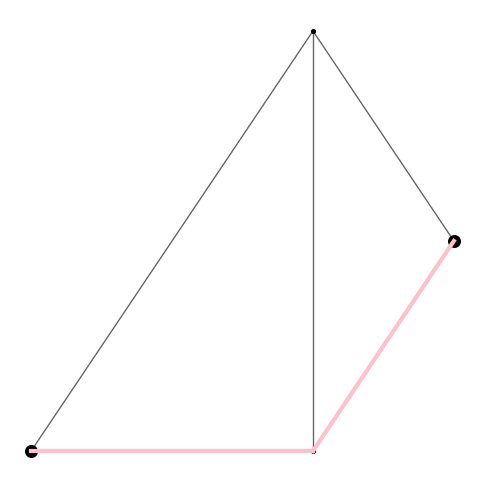

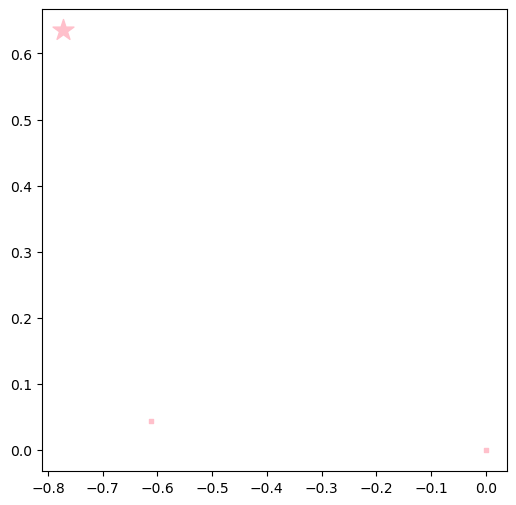

[[-0.77244045  0.6350872 ]]


In [49]:
eps = 1e-3
#alpha_star = (np.sqrt(2)-1)/3 # computed this alpha by hand (optimal path transition)
alpha_star = (np.sqrt(2)-1)/2
alpha = alpha_star - eps

gen_path_edges = augmented_dijkstra(SC, 0, 3, ref_proj_fin[0], alpha)

edges = [(gen_path_edges[i], gen_path_edges[i+1]) for i in range(gen_path_edges.shape[0]-1)]

gen_path = Trajectory(SC, None, None, None)
gen_path.set(edges)

color = 'pink' 

plt.figure(figsize=(6,6))
SC.plot_trajectories(gen_path.all_trajectories, color)
plt.show()

plt.figure(figsize=(6,6))
x_gen, gen_edge_seq = gen_path.trajectory_to_edgevec(gen_path.all_trajectories[0])
gen_proj_seq, gen_proj_fin = gen_path.project_trajectories()
gen_path.plot_trajectory_proj('generated', color)
plt.show()
print(gen_path.project_trajectories()[1])

# Complicated example

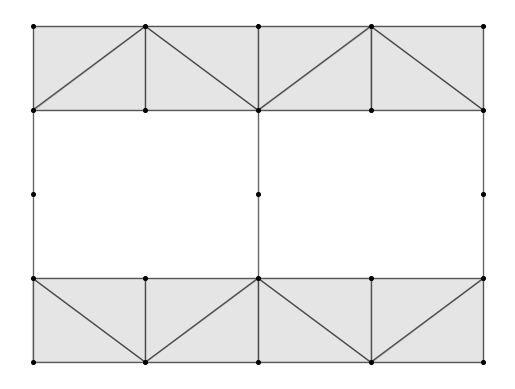

In [35]:
n_side, point_gen_mode = 5, 0
hole_locs = [(-0.5, 0), (0.5, 0)]
r = 0.1

#np.random.seed(1)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts)
all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r)
SC.plot()

[[(0, 1), (1, 2), (2, 7), (7, 12), (12, 17), (17, 22), (22, 23), (23, 24)]]


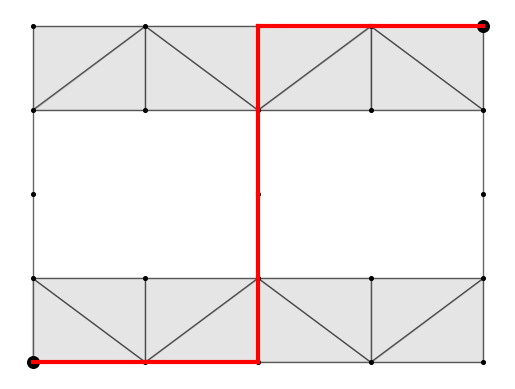

In [36]:
coords = [(-1,-1), (0, -1), (0, 1), (1, 1)]
num_paths, num_nodes = 1, 1

ref_path = Trajectory(SC, coords, num_paths, num_nodes)

x_ref, ref_edge_seq = ref_path.trajectory_to_edgevec(ref_path.all_trajectories[0])
ref_proj_seq, ref_proj_fin = ref_path.project_trajectories()

print(ref_path.all_trajectories)

SC.plot_trajectories(ref_path.all_trajectories, 'red')

In [37]:
alpha = 0
start, end = 0, 24

gen_path_edges = augmented_dijkstra(SC, start, end, ref_proj_fin[0], alpha)
print(gen_path_edges)

KeyboardInterrupt: 

In [ ]:
alpha2 = 1

gen_path_edges2 = augmented_dijkstra(SC, start, end, ref_proj_fin[0], alpha2)
print(gen_path_edges2)